# Intro to AI-driven Science on Supercomputers

## Week 5 Homework

#### Dan Horner (danhorner@berkeley.edu)
---

# Data Pipelines

## Parallel Data Pipeline for ResNet34 Training on ThetaGPU 

I modified the [submission script](../05_dataPipelines/train_resnet34_thetagpu_DAH.sh) to point to my branch of the code and ran it on ThetaGPU for 50 traiing steps over a series of values for the `parallel_threads` and `prefetch_buffer_size` parameters.

To make the plots below:
- saved the output logs for each run in a folder (../05_dataPipelines/HW/)
- zipped that folder up together (so it will be synced to my repo)
- looped through each of the output files end extracted the relevant values
- assembled the values into a pandas.DataFrame to facilitate manipulation

(*Note that I also modified the train_resnet34.py script to print out the parallel threads and prefertch buffer size for easier parsing*)

## Image Throughput Performance Charts

### Set Up

In [1]:
import numpy as np
import pandas as pd

import re
import zipfile

# Plotting library
import plotnine as p9
from plotnine import * 
p9.options.figure_size = (15, 12)

training_report_zip = '../05_dataPipelines/HW.zip'

In [2]:
li = []
zf = zipfile.ZipFile(training_report_zip)
for f in (f for f in zf.namelist() if f.endswith('.output')):
    for line in zf.open(f).readlines():
        if(re.match(b'^parallel threads', line)):
            x = re.search(b'^parallel threads: (?P<threads>\d*)\n', line).groupdict()
        if(re.match(b'^prefetch buffer size', line)):
            x.update(re.search(b'^prefetch buffer size: (?P<buffer>\d*)\n', line).groupdict())
        if(re.match(b'^mean image/s = ', line)):
            x.update(re.search(b'^mean image/s =\s*(?P<mean>\d*\.?\d*)\s*standard deviation:\s*(?P<std>\d*\.?\d*)\n', line).groupdict())
    li.append(x)
zf.close()

df = pd.DataFrame(li).dropna()
for c in df.columns:
    df[c] = df[c].str.decode('utf-8')
df[['threads', 'buffer']] = df[['threads', 'buffer']].astype(int)
df[['mean', 'std']] = df[['mean', 'std']].astype(float)

### Throughput plots

With a few data manipulations to make the plots work better first.

In [3]:
df['logx'] = np.log2(df['threads'])
df['logy'] = np.log2(df['buffer'])
df['laby'] = pd.Categorical(df['buffer'].astype(str), ordered = True, categories = np.sort(df['buffer'].unique()).astype(str) )
df['labmean'] = df['mean'].astype(int).astype(str)

bks = pd.DataFrame({'lab': df['threads'].unique()})
bks['val'] = np.log2(bks['lab'])

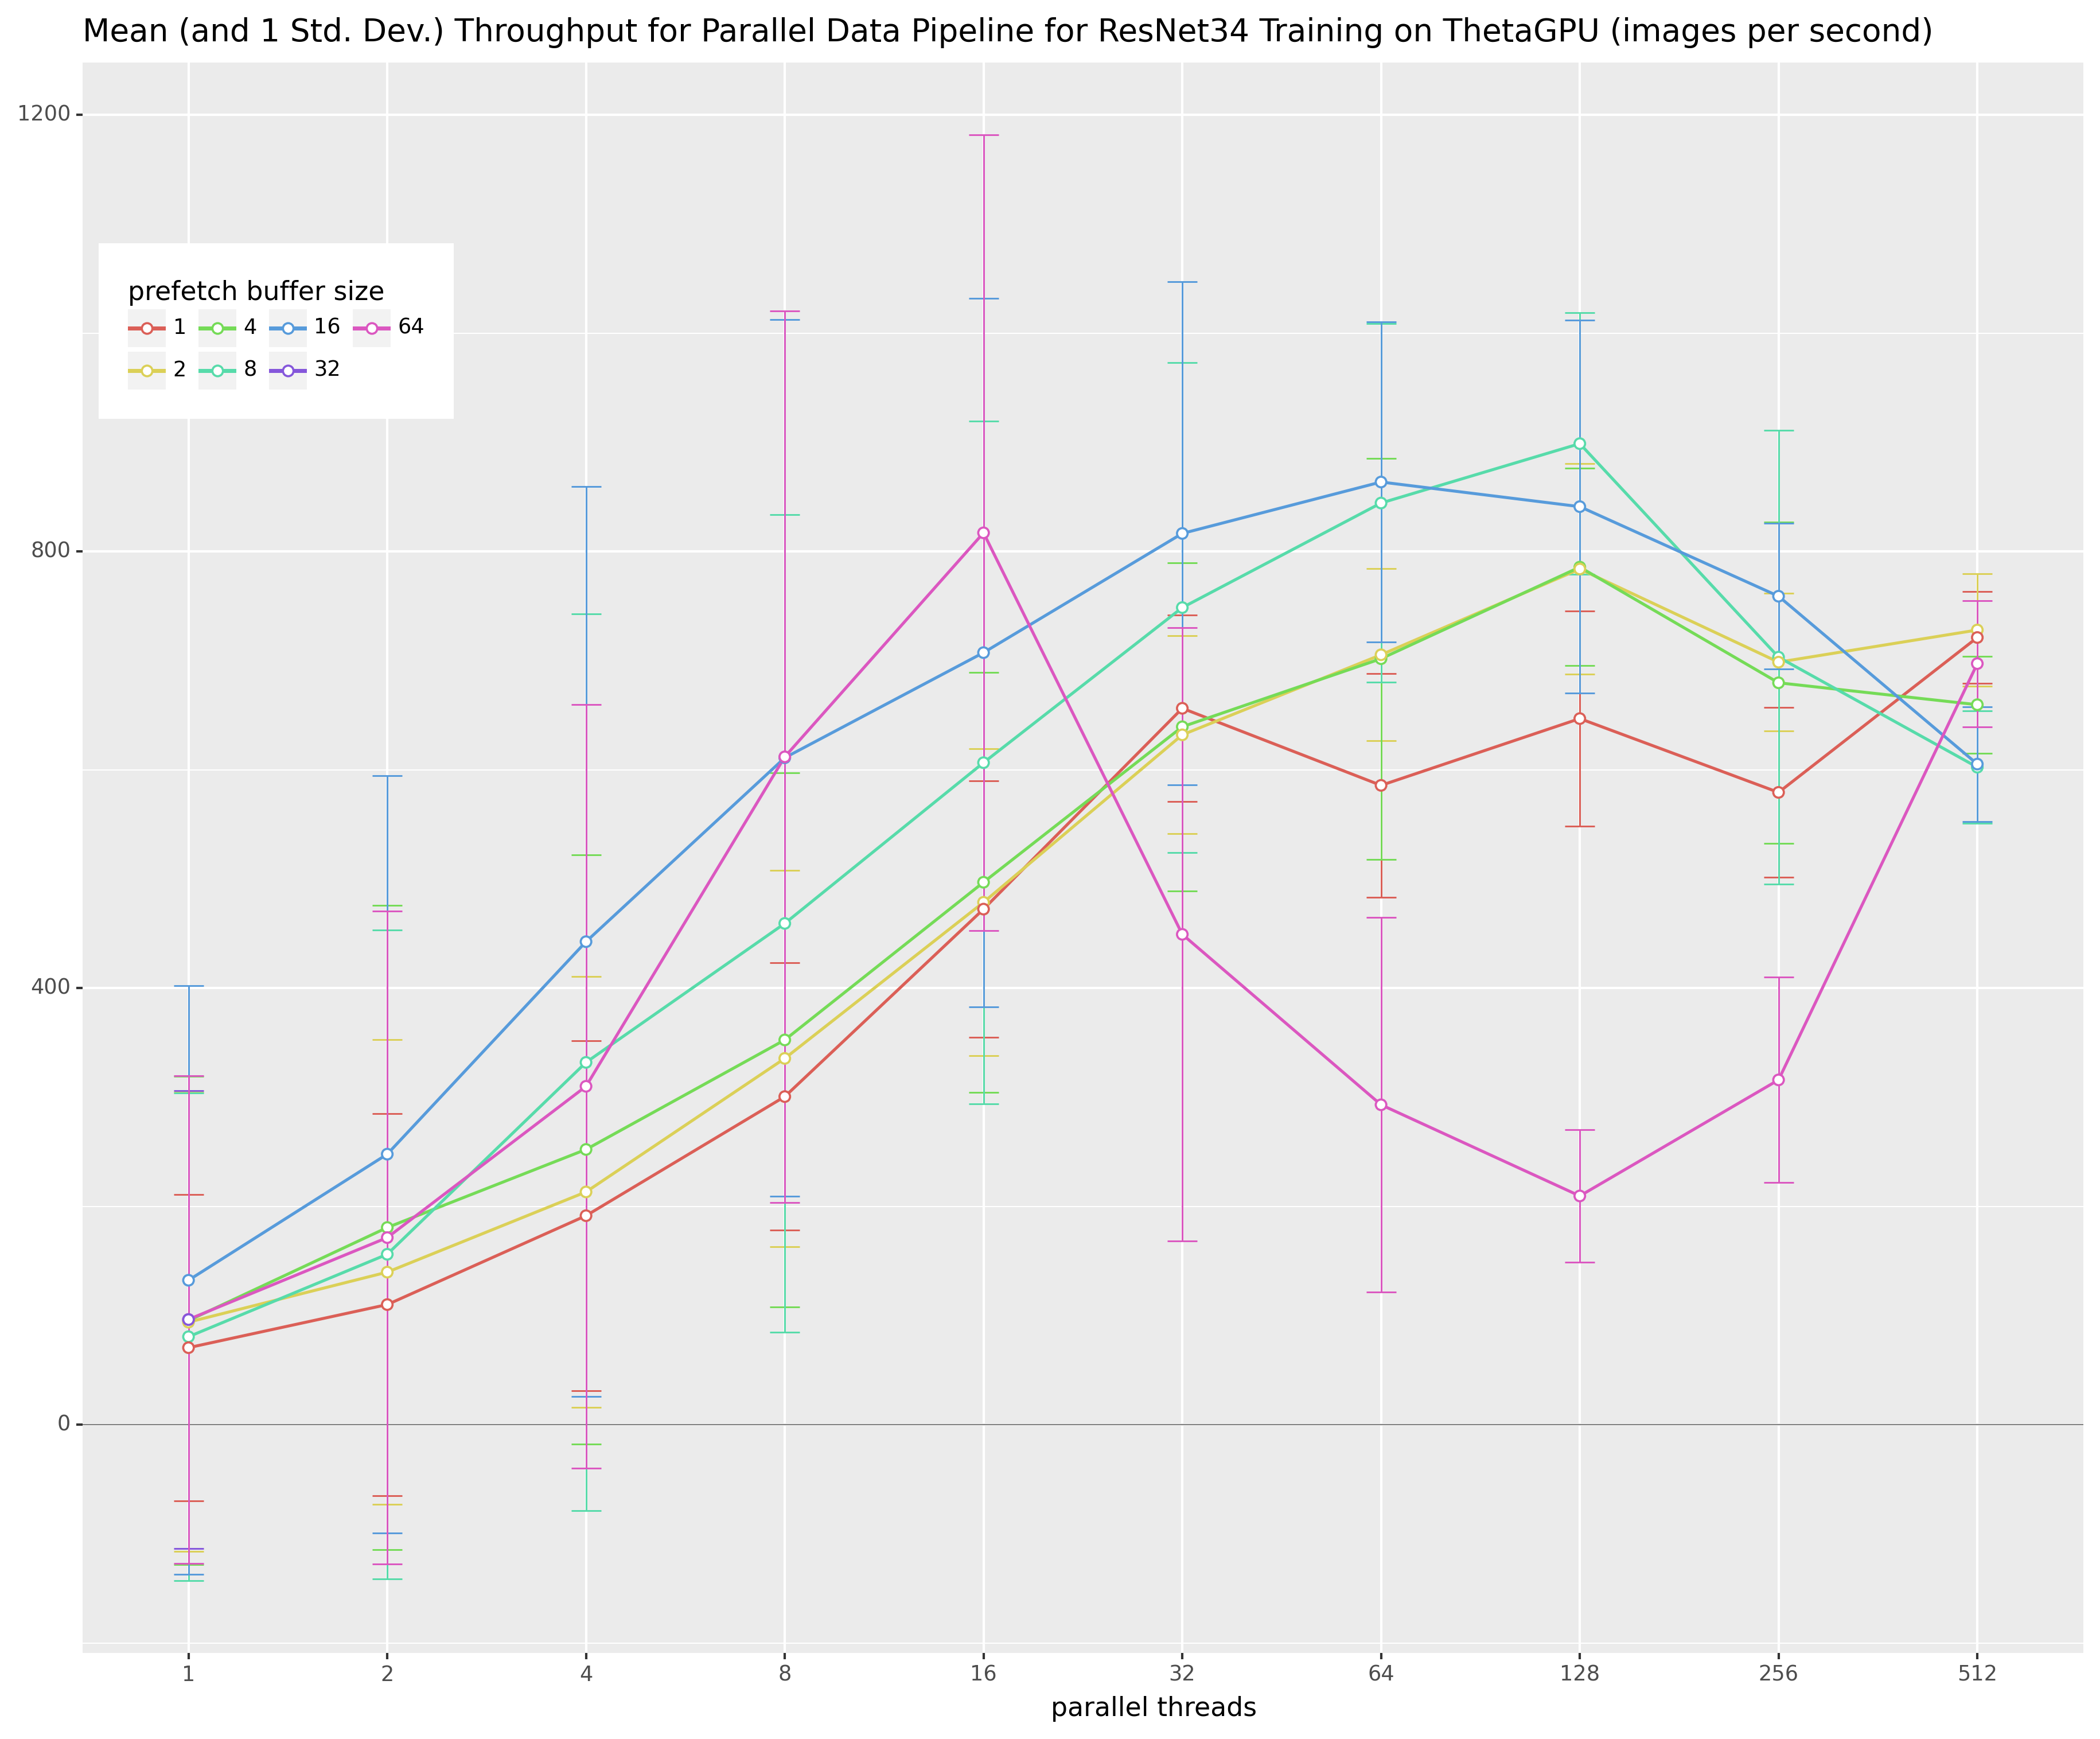

In [4]:
pl = (ggplot()
      + geom_hline(yintercept = 0, colour = 'grey', size = 0.3)
      + geom_linerange(df, aes(x = 'logx', ymin = 'mean - std', ymax = 'mean + std', colour = 'laby'), size = 0.4)
      + geom_errorbar(df, aes(x = 'logx', ymin = 'mean - std', ymax = 'mean + std', colour = 'laby'), size = 0.4, width = 0.15)
      + geom_line(df, aes(x = 'logx', y = 'mean', colour = 'laby'), size = 0.7)
      + geom_point(df, aes(x = 'logx', y = 'mean', colour = 'laby'), fill = 'white', size = 2.0)
      + scale_x_continuous(name = 'parallel threads', breaks = bks['val'], labels = bks['lab'], minor_breaks = None)
      + scale_y_continuous(name = '')
      + scale_colour_discrete(name = 'prefetch buffer size')
      + ggtitle('Mean (and 1 Std. Dev.) Throughput for Parallel Data Pipeline for ResNet34 Training on ThetaGPU (images per second)')
      +theme(
          dpi = 300,
          legend_position = (0.20, 0.75),
          title = element_text(ha = 'left'),
      )
     )
print(pl)

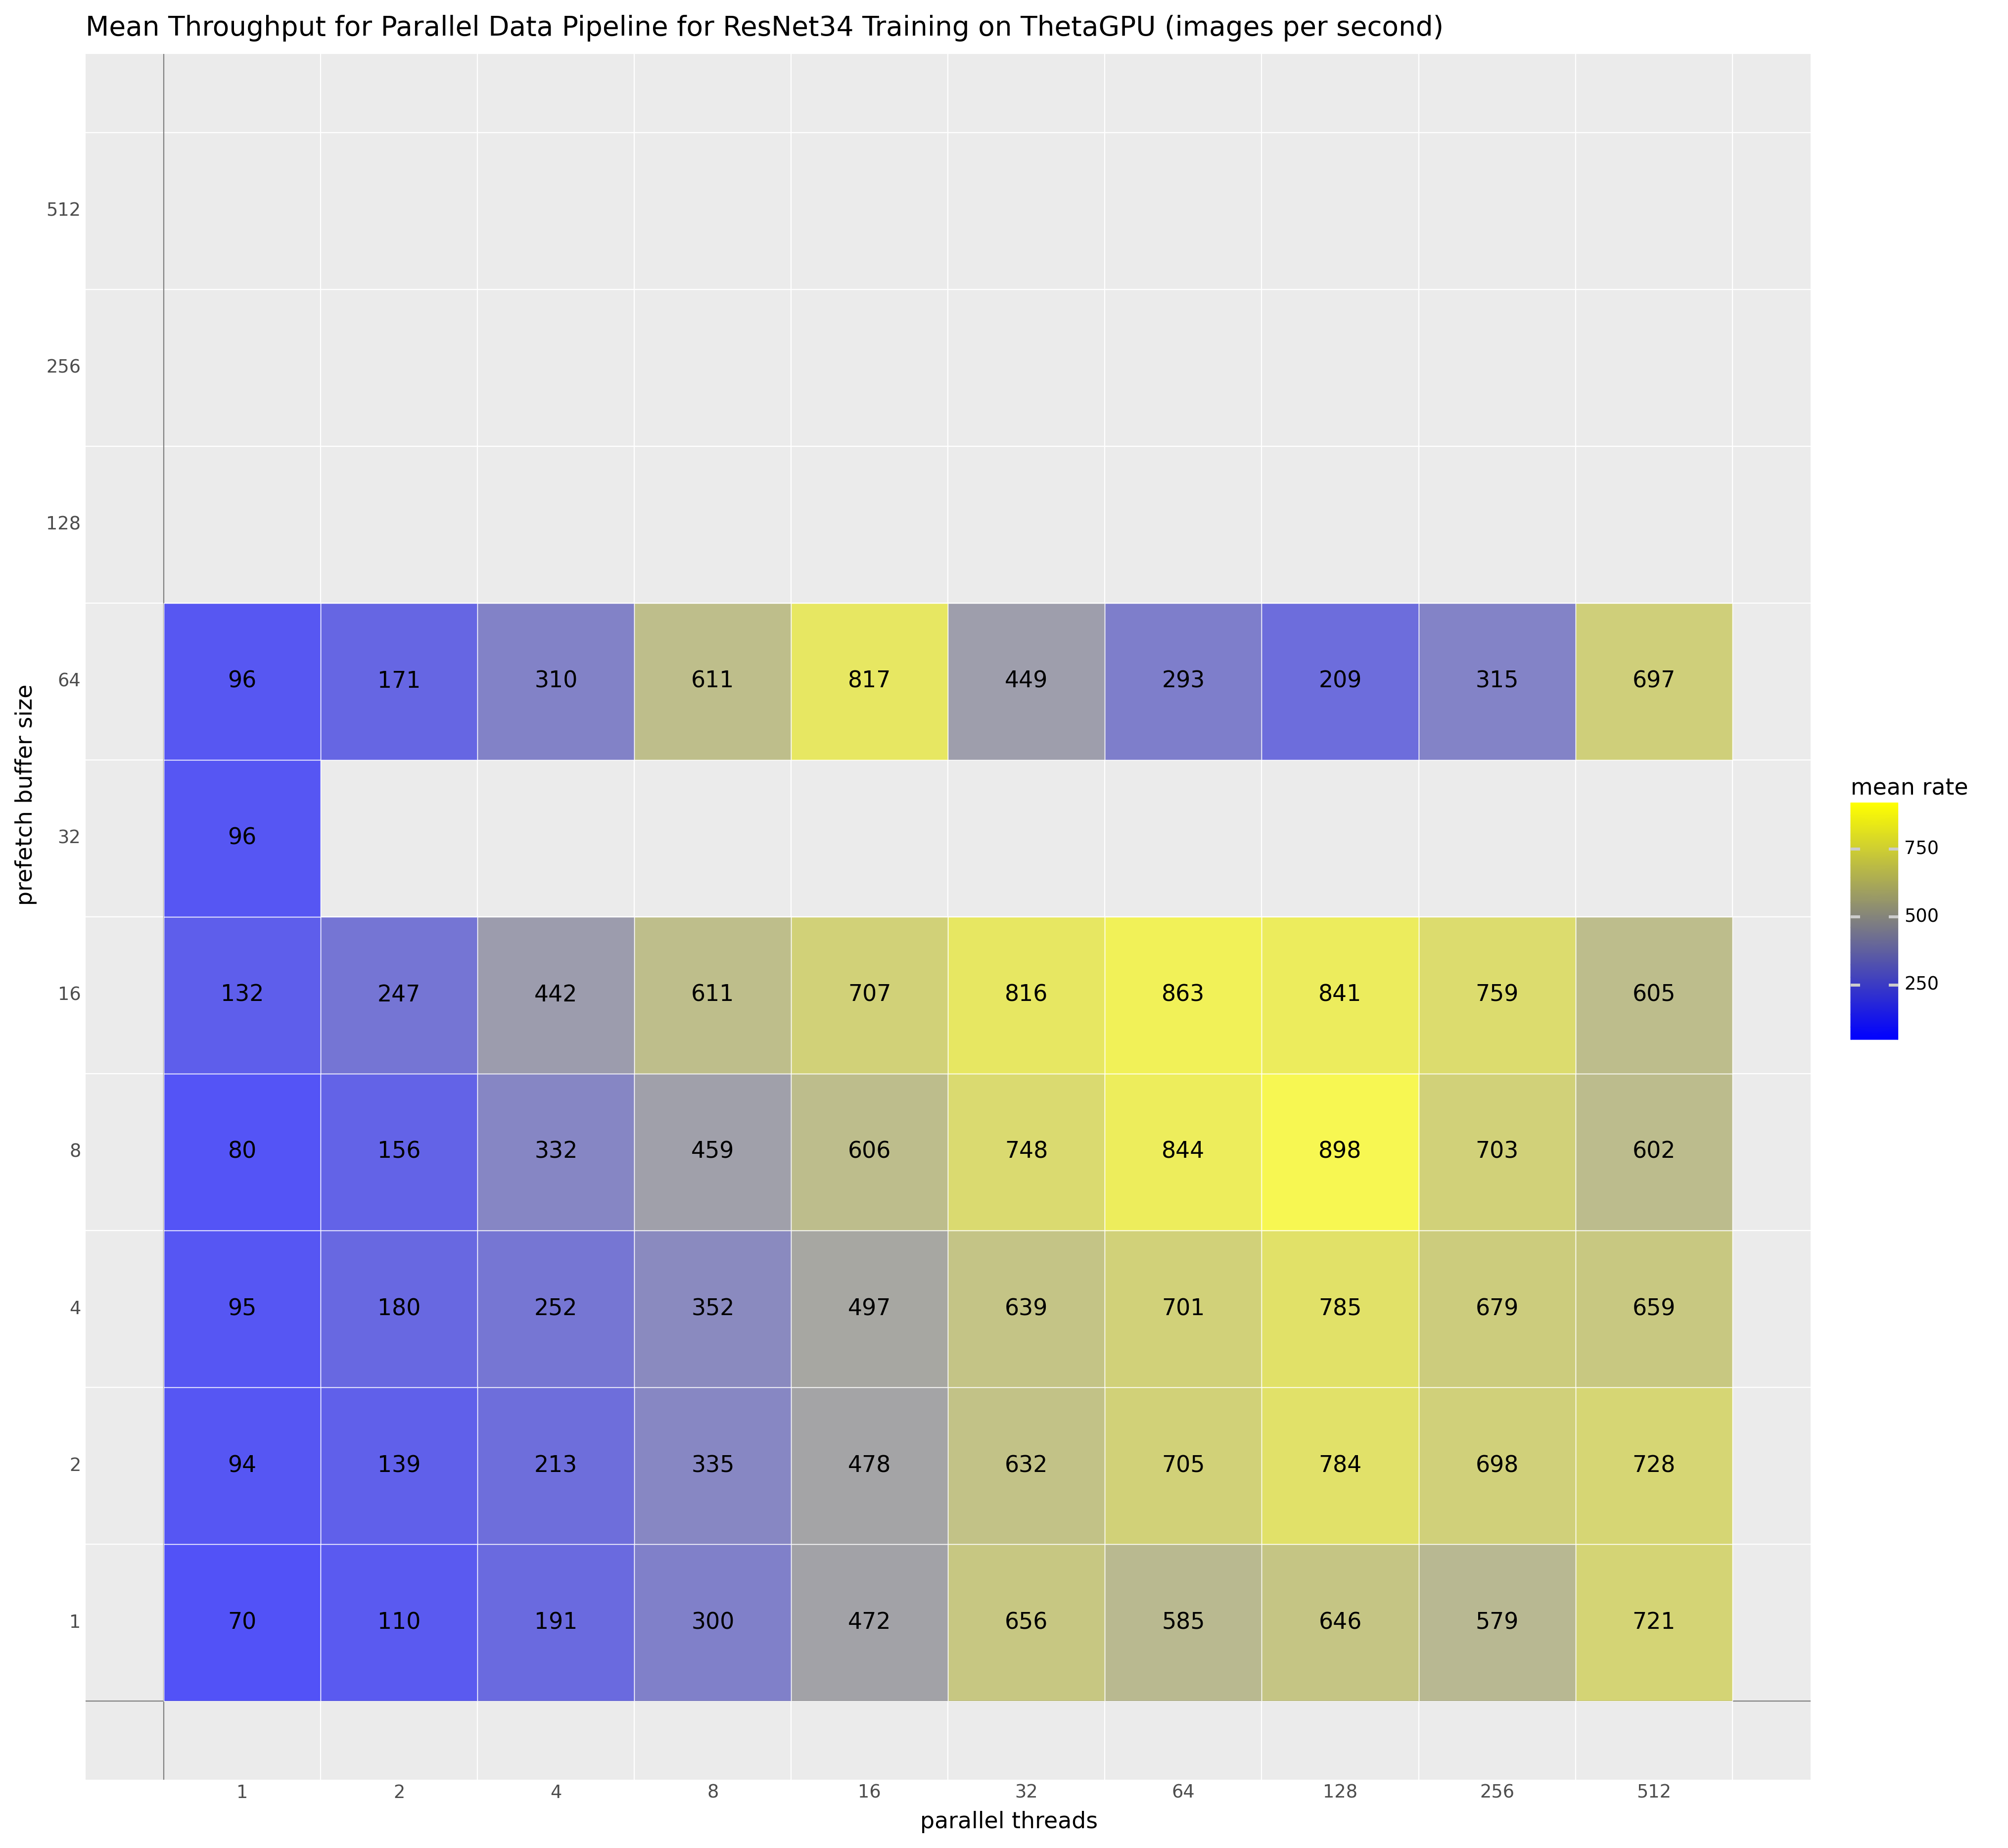

In [5]:
pl = (ggplot()
      + geom_hline(yintercept = np.arange(1, 11) - 0.5, colour = 'white', size = 0.3)
      + geom_vline(xintercept = np.arange(1, 11) - 0.5, colour = 'white', size = 0.3)
      + geom_hline(yintercept = -0.5, colour = 'grey', size = 0.3)
      + geom_vline(xintercept = -0.5, colour = 'grey', size = 0.3)
      + geom_tile(df, aes(x = 'logx', y = 'logy', fill = 'mean'), colour = 'white', size = 0.2, alpha = 0.65)
      + geom_text(df, aes(x = 'logx', y = 'logy', label = 'labmean'))
      + scale_x_continuous(name = 'parallel threads', breaks = bks['val'], labels = bks['lab'], minor_breaks = None)
      + scale_y_continuous(name = 'prefetch buffer size', breaks = bks['val'], labels = bks['lab'], minor_breaks = None)
      + scale_fill_gradient(name = 'mean rate', low = 'blue', high = 'yellow')
      + ggtitle('Mean Throughput for Parallel Data Pipeline for ResNet34 Training on ThetaGPU (images per second)')
      + coord_fixed()
      + theme(
          title = element_text(ha = 'left'),
          dpi = 300,
          panel_grid=element_blank(),
          axis_ticks_length=0,
          
      )
     )
print(pl)

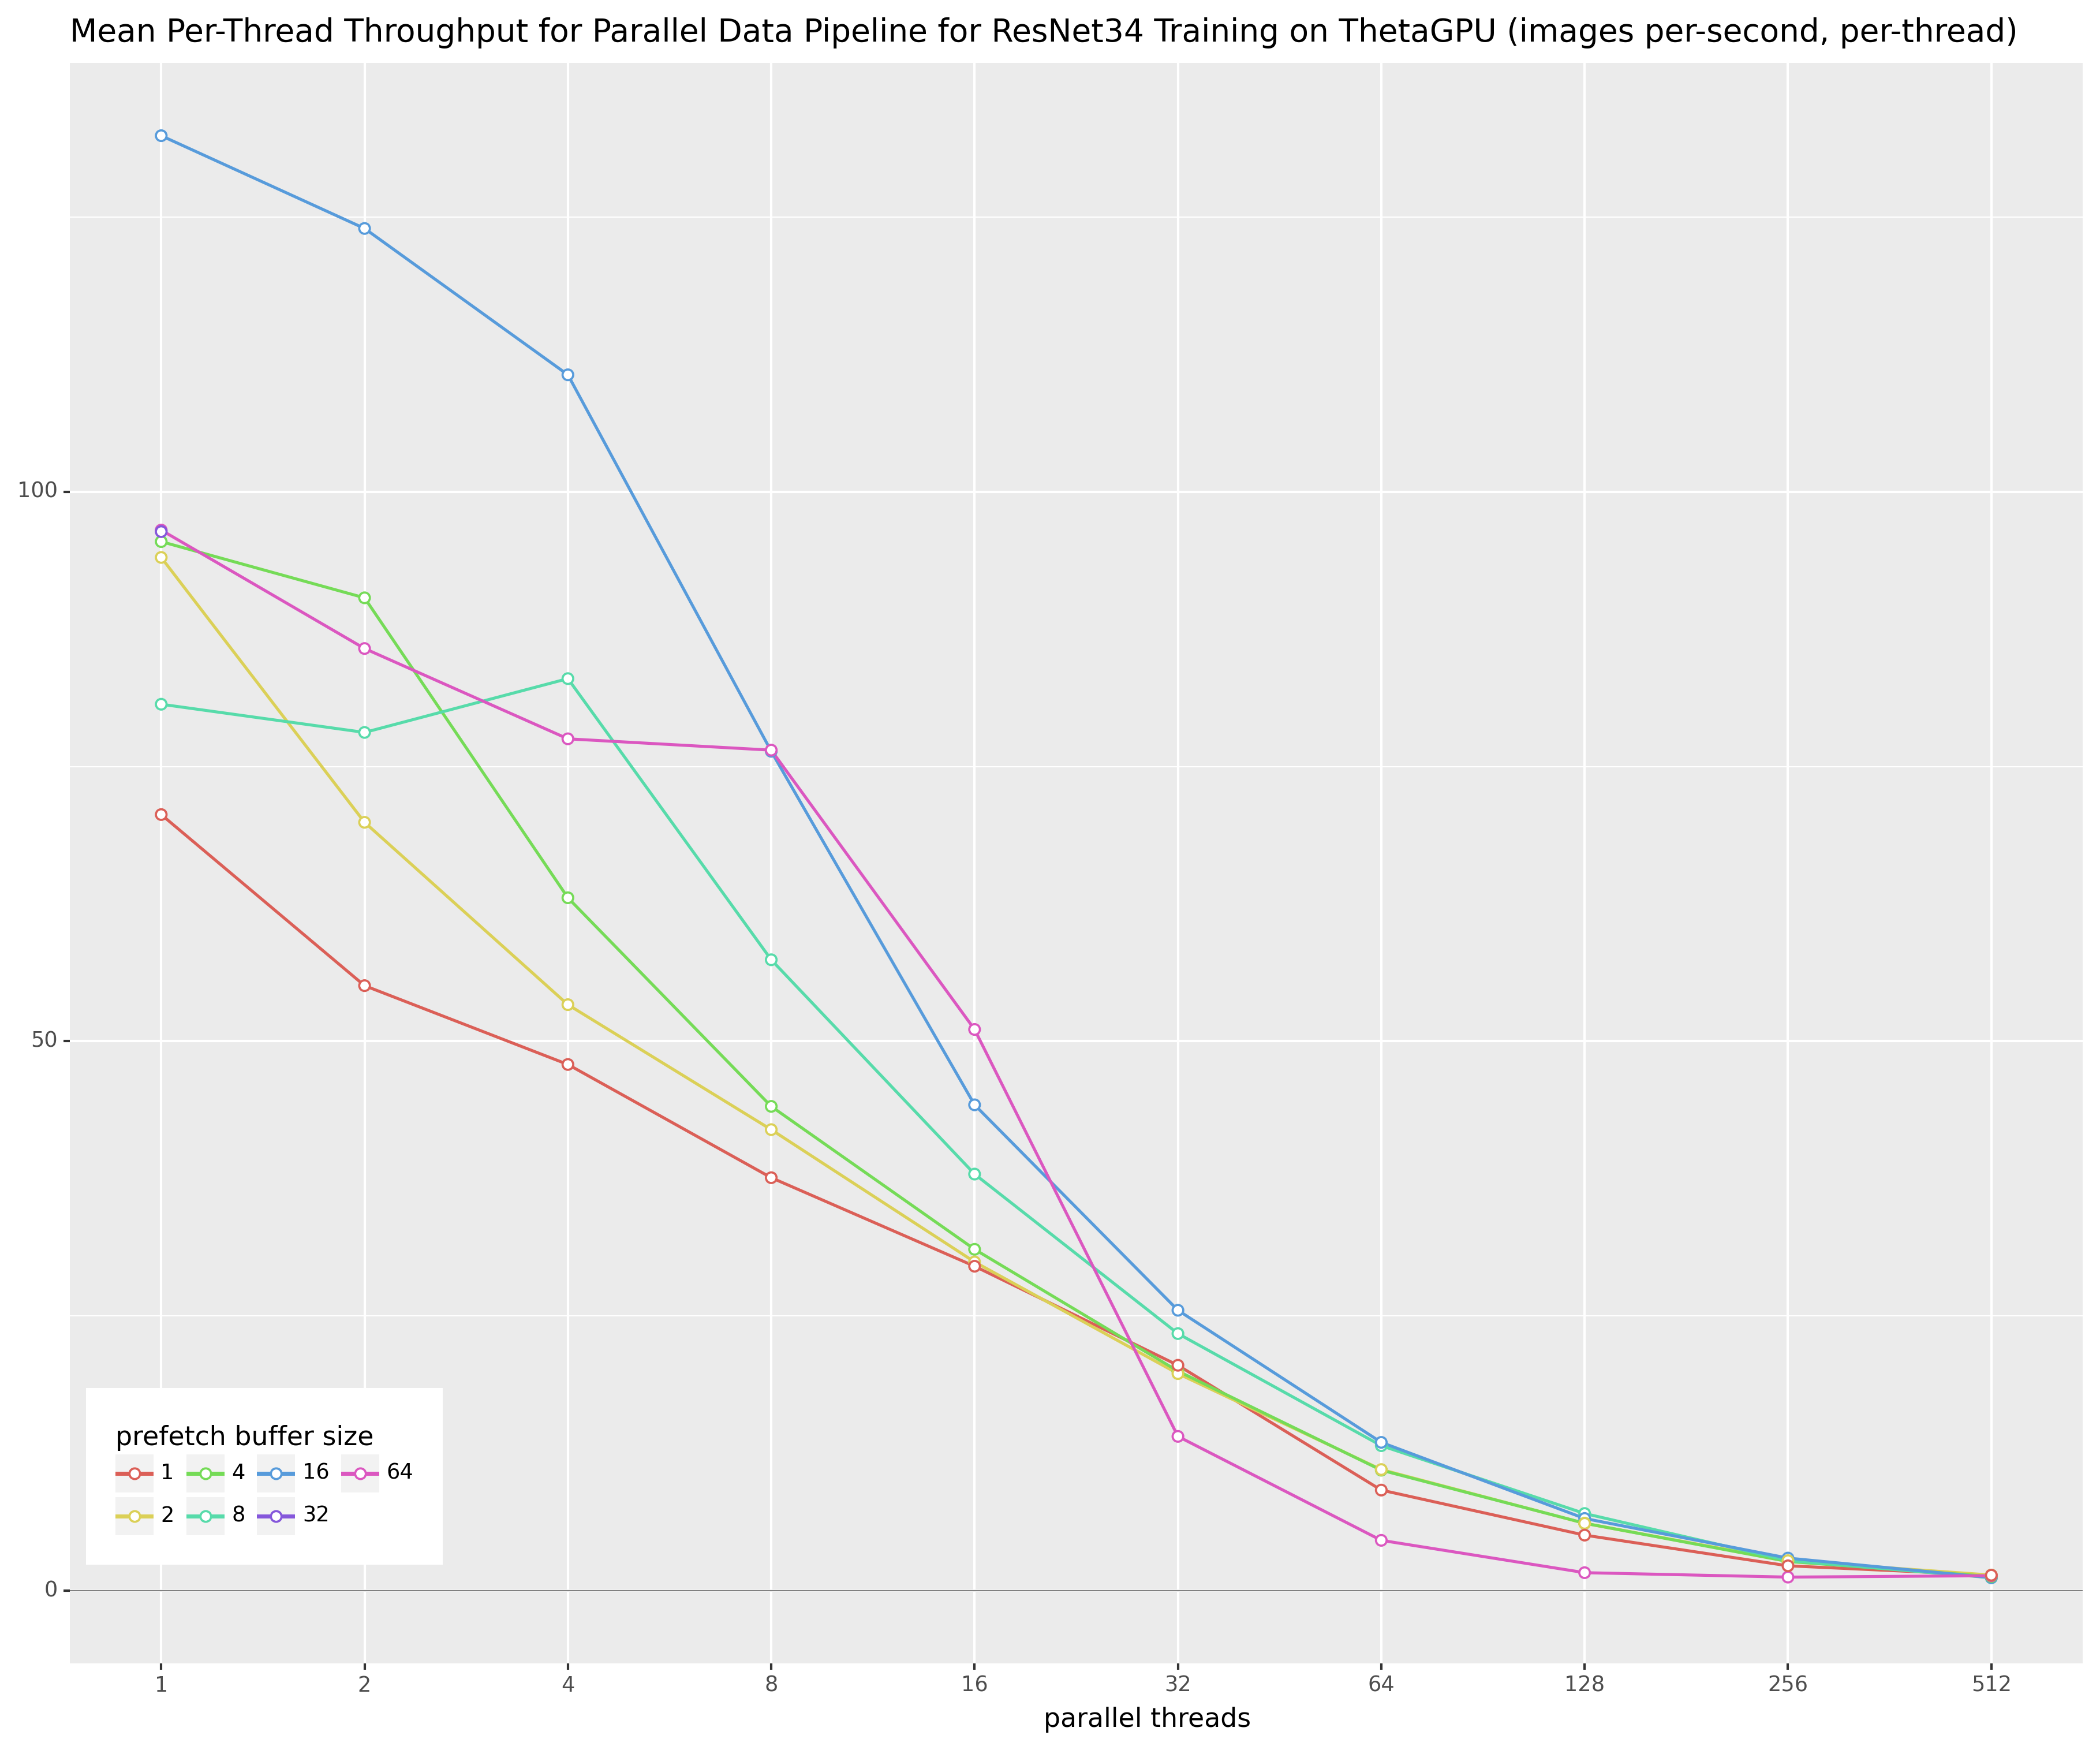

In [6]:
pl = (ggplot()
      + geom_hline(yintercept = 0, colour = 'grey', size = 0.3)
      + geom_line(df, aes(x = 'logx', y = 'mean/threads', colour = 'laby'), size = 0.7)
      + geom_point(df, aes(x = 'logx', y = 'mean/threads', colour = 'laby'), fill = 'white', size = 2.0)
      + scale_x_continuous(name = 'parallel threads', breaks = bks['val'], labels = bks['lab'], minor_breaks = None)
      + scale_y_continuous(name = '')
      + scale_colour_discrete(name = 'prefetch buffer size')
      + ggtitle('Mean Per-Thread Throughput for Parallel Data Pipeline for ResNet34 Training on ThetaGPU (images per-second, per-thread)')
      +theme(
          dpi = 300,
          legend_position = (0.2, 0.2),
          title = element_text(ha = 'left'),
      )
     )
print(pl)

### Discussion

Unsurprisingly, increasing the number of parallel threads and the prefetch batch size generally increases the image throughput. However, as the number of parallel threads increases past 128, the throughput rate decreases.

Additionally while more parallel threads increase the throughput, the scaling is not linear and the per-thread throughput virtually always decreases as the number of parallel threads increases.

Finally, there seems to be odd behaviour for the runs with prefetch buffer size of 64: with more than 16 parallel threads, the throughput plummets, but then increases again for greater than 128 parallel threads.

(*Note that some combinations of parallel threads and prefetch buffer size were not run and , accordingly not shown in the charts.*)